In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

from scipy import stats
from scipy.special import expit as logistic

import arviz as az

import math

import pygame

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


### Loading pickles regarding data and map estimates for hyperparemeters from non-spars estimation

In [2]:
# Tror mpske kun jeg skal bruge point...

pkl_file = open('train_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
pkl_file = open('sce_huper_para_dict.pkl', 'rb')

sce_hp_dict = pickle.load(pkl_file)

pkl_file.close()

In [4]:
mp = {}
mp['η'] = np.array([np.mean(sce_hp_dict['η'])])
mp['η_log__'] = np.array([np.log(np.mean(sce_hp_dict['η']))])

mp['σ'] = np.array([np.mean(sce_hp_dict['σ'])])
mp['σ_log__'] = np.array([np.log(np.mean(sce_hp_dict['σ']))])

mp['ℓ'] = np.array([np.mean(sce_hp_dict['ℓ'])])
mp['ℓ_log__'] = np.array([np.log(np.mean(sce_hp_dict['ℓ']))])

mp

{'η': array([0.18716566]),
 'η_log__': array([-1.67576116]),
 'σ': array([0.45765366]),
 'σ_log__': array([-0.78164258]),
 'ℓ': array([1.09422525]),
 'ℓ_log__': array([0.09004658])}

In [5]:
# OLD
# MAP estimates from non-spars estimation
# mp

In [6]:
#OLD
# The data

# year = df['year'].max()

# y_north_limit = 50
# y_south_limit = - 10
# x_east_limit = 100
# x_west_limit  = -20

# df_sub = df[(df['year']==year)&(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]


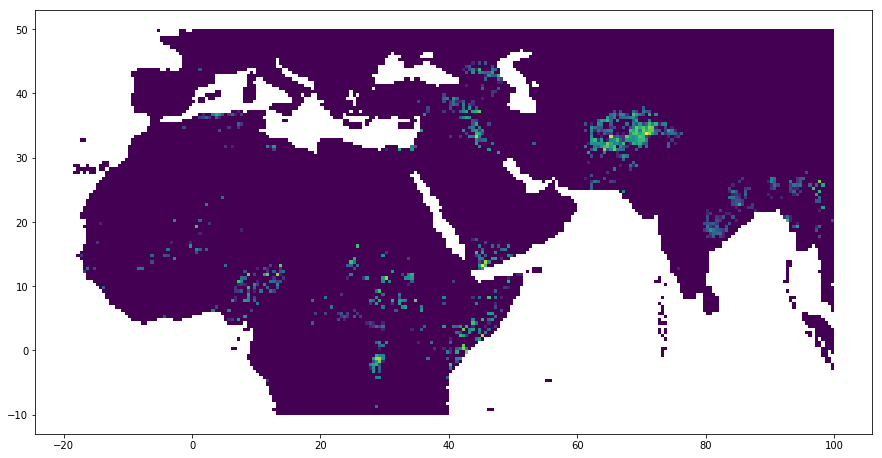

In [7]:
df[df['year']==df['year'].max()].plot(column = 'log_best', figsize=(15, 15))
plt.show()

# Set hyper paramters (from Pickle_hp_sce_all_years)

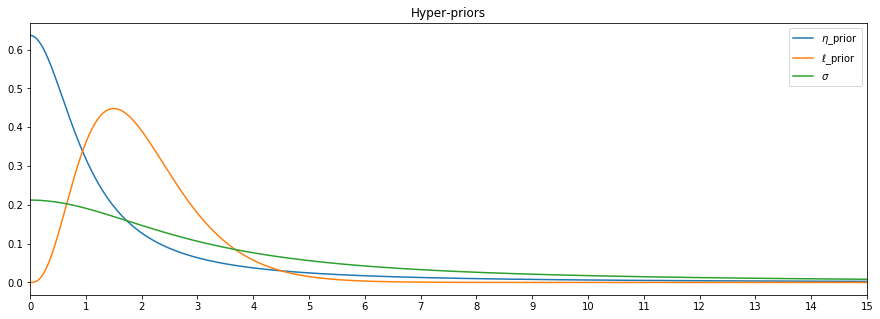

In [8]:
η_beta = 1
ℓ_beta = 2
ℓ_alpha = 4
σ_beta = 3

grid = np.linspace(0,15,1000)
priors = [
    ('$\eta$_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('$\ell$_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('$\sigma$', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('Hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.xticks(np.arange(0,16,1))
plt.xlim(0,15)
plt.legend()
plt.show()

## Estimation
In function:

In [9]:
def get_year_data(year):
#     df_sub = df[(df['year']==year)&(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]
    df_sub = df[(df['year']==year)]

    X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T
    y = np.array(df_sub['log_best'])
    
    # for spares
    sub1 = df_sub[df_sub['best']>0]
    Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T

    return(X, y, Xu)

In [10]:
def model_est(y, X, Xu):    
    # The Model
    with pm.Model() as model:

        # lenght-scale and amplitude hyperparameter for the spatial dispertion
        ℓ = pm.Gamma("ℓ", alpha=2, beta=2, shape = 1)
        η = pm.HalfCauchy("η", beta=5, shape = 1)


        # noise
        σ = pm.HalfCauchy("σ", beta=2, shape = 1)
        
        # Covariance. Assume long. and lat share on cov_func.
        cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
        # The GP
        gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC") # ved ikke om det gør en forskel til FICT
        y_ = gp.marginal_likelihood("y_", X=X, Xu = Xu, y=y, noise= σ)
        
    mu, var = gp.predict(X, point=mp, given = {'gp' : gp, 'X' : X, 'y' : y, 'noise' : σ }, diag=True)
        
    return(mu, var)

In [11]:
def model_run(year):
    # timer
    time0 = time.time()
    
    # get the year specific data:
    X, y, Xu = get_year_data(year = year)
    
    # model funcs
    mu, var = model_est(y=y, X = X, Xu = Xu)
    
    # Time stamp:
    time2 = time.time()
    timet = (time2 - time0)/60
    print('toltal: {} min'.format(timet))
   

    file_name = "spatial_est_{}.pkl".format(year)
    output = open(file_name, 'wb') 
    
    estimates = {'mu':mu,'var':var}
    
    pickle.dump(estimates, output)
    output.close()

    # output:
#     return(mu,var)

In [12]:
def model_loop(start, end):    
    year_list = np.sort(df['year'].unique())

    for i in year_list[start:end]:
        year = i
        model_run(year)
        print('{} done\n'.format(i))

    print('DONE!')

# IMPORTANT

So for some reason my memory gets clogged and I have tried every thing to ammend this in the loop with no real succes. Running alle cells below will take up more then 32 GB ram (mayby even more then 64..). Thus I am now simply runnig the notebook 7 times. Each time only running **ONE of the following cells!**. Afterwards I restart the ptyhon kernel, run the cells above again and then **ONE** new cell below. Iterate ontil all years are estimated.

In [13]:
def done_tune():
    # Play a tune when done.
    path ='/home/polichinel/Downloads/mp3/FFVII Victory Fanfare Ringtone(Dracotonis).mp3'

    pygame.mixer.init()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()

In [15]:
model_loop(0,5)
done_tune()

toltal: 0.6891950925191244 min
1989 done

toltal: 0.7838783939679463 min
1990 done

toltal: 0.8881757537523906 min
1991 done

toltal: 1.3927565693855286 min
1992 done

toltal: 1.298255205154419 min
1993 done

DONE!


In [14]:
model_loop(5,10)
done_tune()

toltal: 1.6921988010406495 min
1994 done

toltal: 1.8712902983029684 min
1995 done

toltal: 1.27759739557902 min
1996 done

toltal: 1.4552641669909159 min
1997 done

toltal: 2.102563007672628 min
1998 done

DONE!


In [14]:
model_loop(10,15)
done_tune()

toltal: 1.7731190284093221 min
1999 done

toltal: 1.909972329934438 min
2000 done

toltal: 1.572568698724111 min
2001 done

toltal: 1.8013494928677878 min
2002 done

toltal: 1.4193392753601075 min
2003 done

DONE!


In [14]:
model_loop(15,20)
done_tune()

toltal: 2.0301276365915935 min
2004 done

toltal: 1.7650530298550924 min
2005 done

toltal: 2.0787113269170123 min
2006 done

toltal: 2.3112385670344033 min
2007 done

toltal: 2.477169620990753 min
2008 done

DONE!


In [14]:
model_loop(20,24)
done_tune()

toltal: 2.404780968030294 min
2009 done

toltal: 2.2328540086746216 min
2010 done

toltal: 2.6466283480326336 min
2011 done

toltal: 2.848659837245941 min
2012 done

DONE!


# load a test pickle and show:

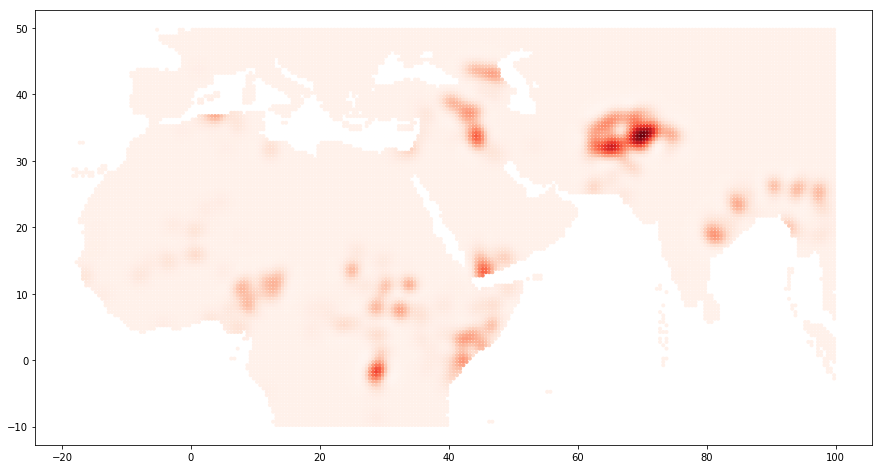

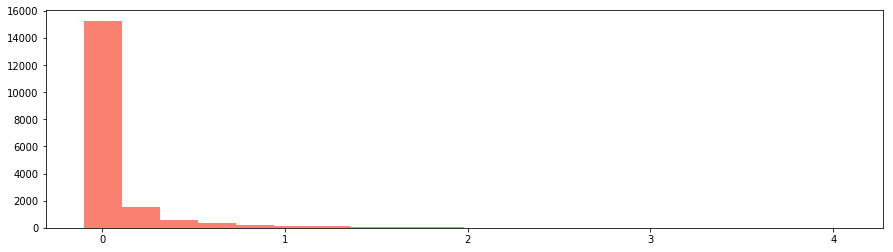

In [15]:
pkl_file = open('spatial_est_2012.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df[df['year']==2012]['xcoord'], df[df['year']==2012]['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')

plt.figure(figsize=[15,4])
plt.hist(estimates['mu'], color = 'salmon', bins = 20)
plt.show()
